In [1]:
import numpy as np
import matplotlib as plt
import math
from pylab import *

In [2]:
def get_poisson_prob(p_lambda,n):
    ans=1.0
    for i in range(1,n+1):
        ans=ans*p_lambda/i
    ans=ans*math.exp(-p_lambda)
    return ans

In [3]:
gamma=0.9
max_car_num=20
x=[]
y=[]
for i in range(441):
    x.append(i/21)
    y.append(i%21)

v=[] #第1个车库有i辆车，第二个车库有j辆车的价值函数
pi=[] #第1个车库有i辆车，第二个车库有j辆车时候的动作
for i in range(max_car_num+1):
    v.append([0]*(max_car_num+1))
    pi.append([0]*(max_car_num+1))


In [4]:
class place:
    def __init__(self,rent_lambda,return_lambda):    
        self.prob=[] #从i辆车转移到j辆车的概率
        for i in range(max_car_num+1):
            self.prob.append([0]*(max_car_num+1))
        self.rent_lambda=rent_lambda
        self.return_lambda=return_lambda
        self.eps=1e-15
        self.reward=[0]*(max_car_num+1) #当前有i辆车的期望收益
        for num in range(0,max_car_num+1):
            for i in range(0,max_car_num+1):
                rent_num=i
                rent_prob=get_poisson_prob(self.rent_lambda,i)
                rent_num=min(num,rent_num)
                self.reward[num]+=rent_prob*rent_num*10
                for j in range(0,max_car_num+1):
                    return_num=j
                    return_prob=get_poisson_prob(self.return_lambda,j)
                    if rent_prob*return_prob<self.eps:
                        continue
                    new_num=min(20,num-rent_num+return_num)
                    self.prob[num][new_num]+=rent_prob*return_prob
                    
place_1=place(3,3)
place_2=place(4,2)

In [5]:
def get_reward(i,j,move_num):
    new_car_i=min(i-move_num,20)
    new_car_j=min(j+move_num,20)
    reward=(-2)*abs(move_num)
    for ii in range(0,max_car_num+1):
        for jj in range(0,max_car_num+1):
            reward+=place_1.prob[new_car_i][ii]*place_2.prob[new_car_j][jj]*(place_1.reward[new_car_i]+place_2.reward[new_car_j]+gamma*v[ii][jj])
    return reward

In [6]:
#策略评估
def evaluation():
    while True:
        Delta=0
        theta=0.1
        for i in range(max_car_num+1):
            for j in range(max_car_num+1):
                last_v=v[i][j]
                v[i][j]=get_reward(i,j,pi[i][j])
                Delta=max(Delta,abs(last_v-v[i][j]))
        if Delta<theta:
            break

In [7]:
#策略改进
def get_greedy(i,j):
    action_value=dict()
    for cars in range(-5,6):
        if i<cars or j+cars<0:
            continue
        action_value[cars]=get_reward(min(i,20),min(j,20),cars)
    max_value=0
    for key in action_value:
        max_value=max(action_value[key],max_value)
    best_action=[]
    for key in action_value:
        if(action_value[key]==max_value):
            best_action.append(key)
    return best_action

def improvement():
    policy_stable=True
    for i in range(max_car_num+1):
        for j in range(max_car_num+1):
            #print(i,j)
            old_action=pi[i][j]
            best_action=get_greedy(i,j)
            f=False
            for index in best_action:
                if index==old_action:
                    f=True
            policy_stable&=f
            pi[i][j]=np.random.choice(best_action)
    return policy_stable

In [8]:
iter_v=[]
iter_pi=[]
def iteration():
    f=False
    iter_num=0
    while(not f):
        #print(f)
        iter_num+=1
        evaluation()
        f|=improvement()
        if(f==True):
            break
            
        pii=[]
        vv=[]
        for i in range(max_car_num+1):
            l=[]
            ll=[]
            for j in range(max_car_num+1):
                l.append(pi[i][j])
                ll.append(v[i][j])
            pii.append(l)
            vv.append(ll)
        iter_v.append(vv)
        iter_pi.append(pii)

In [9]:
iteration()

In [10]:
def draw_value(fig_num):
    fig=plt.figure(1)
    AX=fig.add_subplot(111,projection='3d')
    AX.set_title('Value')
    x=[]
    y=[]
    z=[]
    for i in range (max_car_num+1):
        for j in range (max_car_num+1):
            x.append(i)
            y.append(j)
            z.append(iter_v[fig_num][i][j])
    AX.set_ylabel('number of cars at place 1',fontsize=5)
    AX.set_xlabel('number of cars at place 2',fontsize=5)
    AX.scatter(x,y,z)  

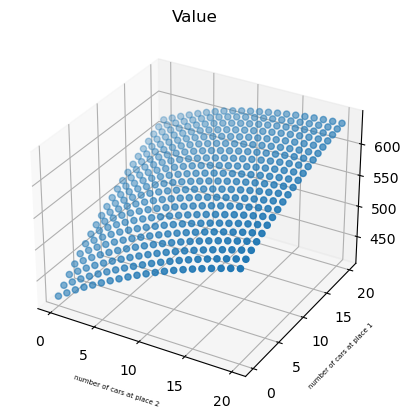

In [11]:
draw_value(2)

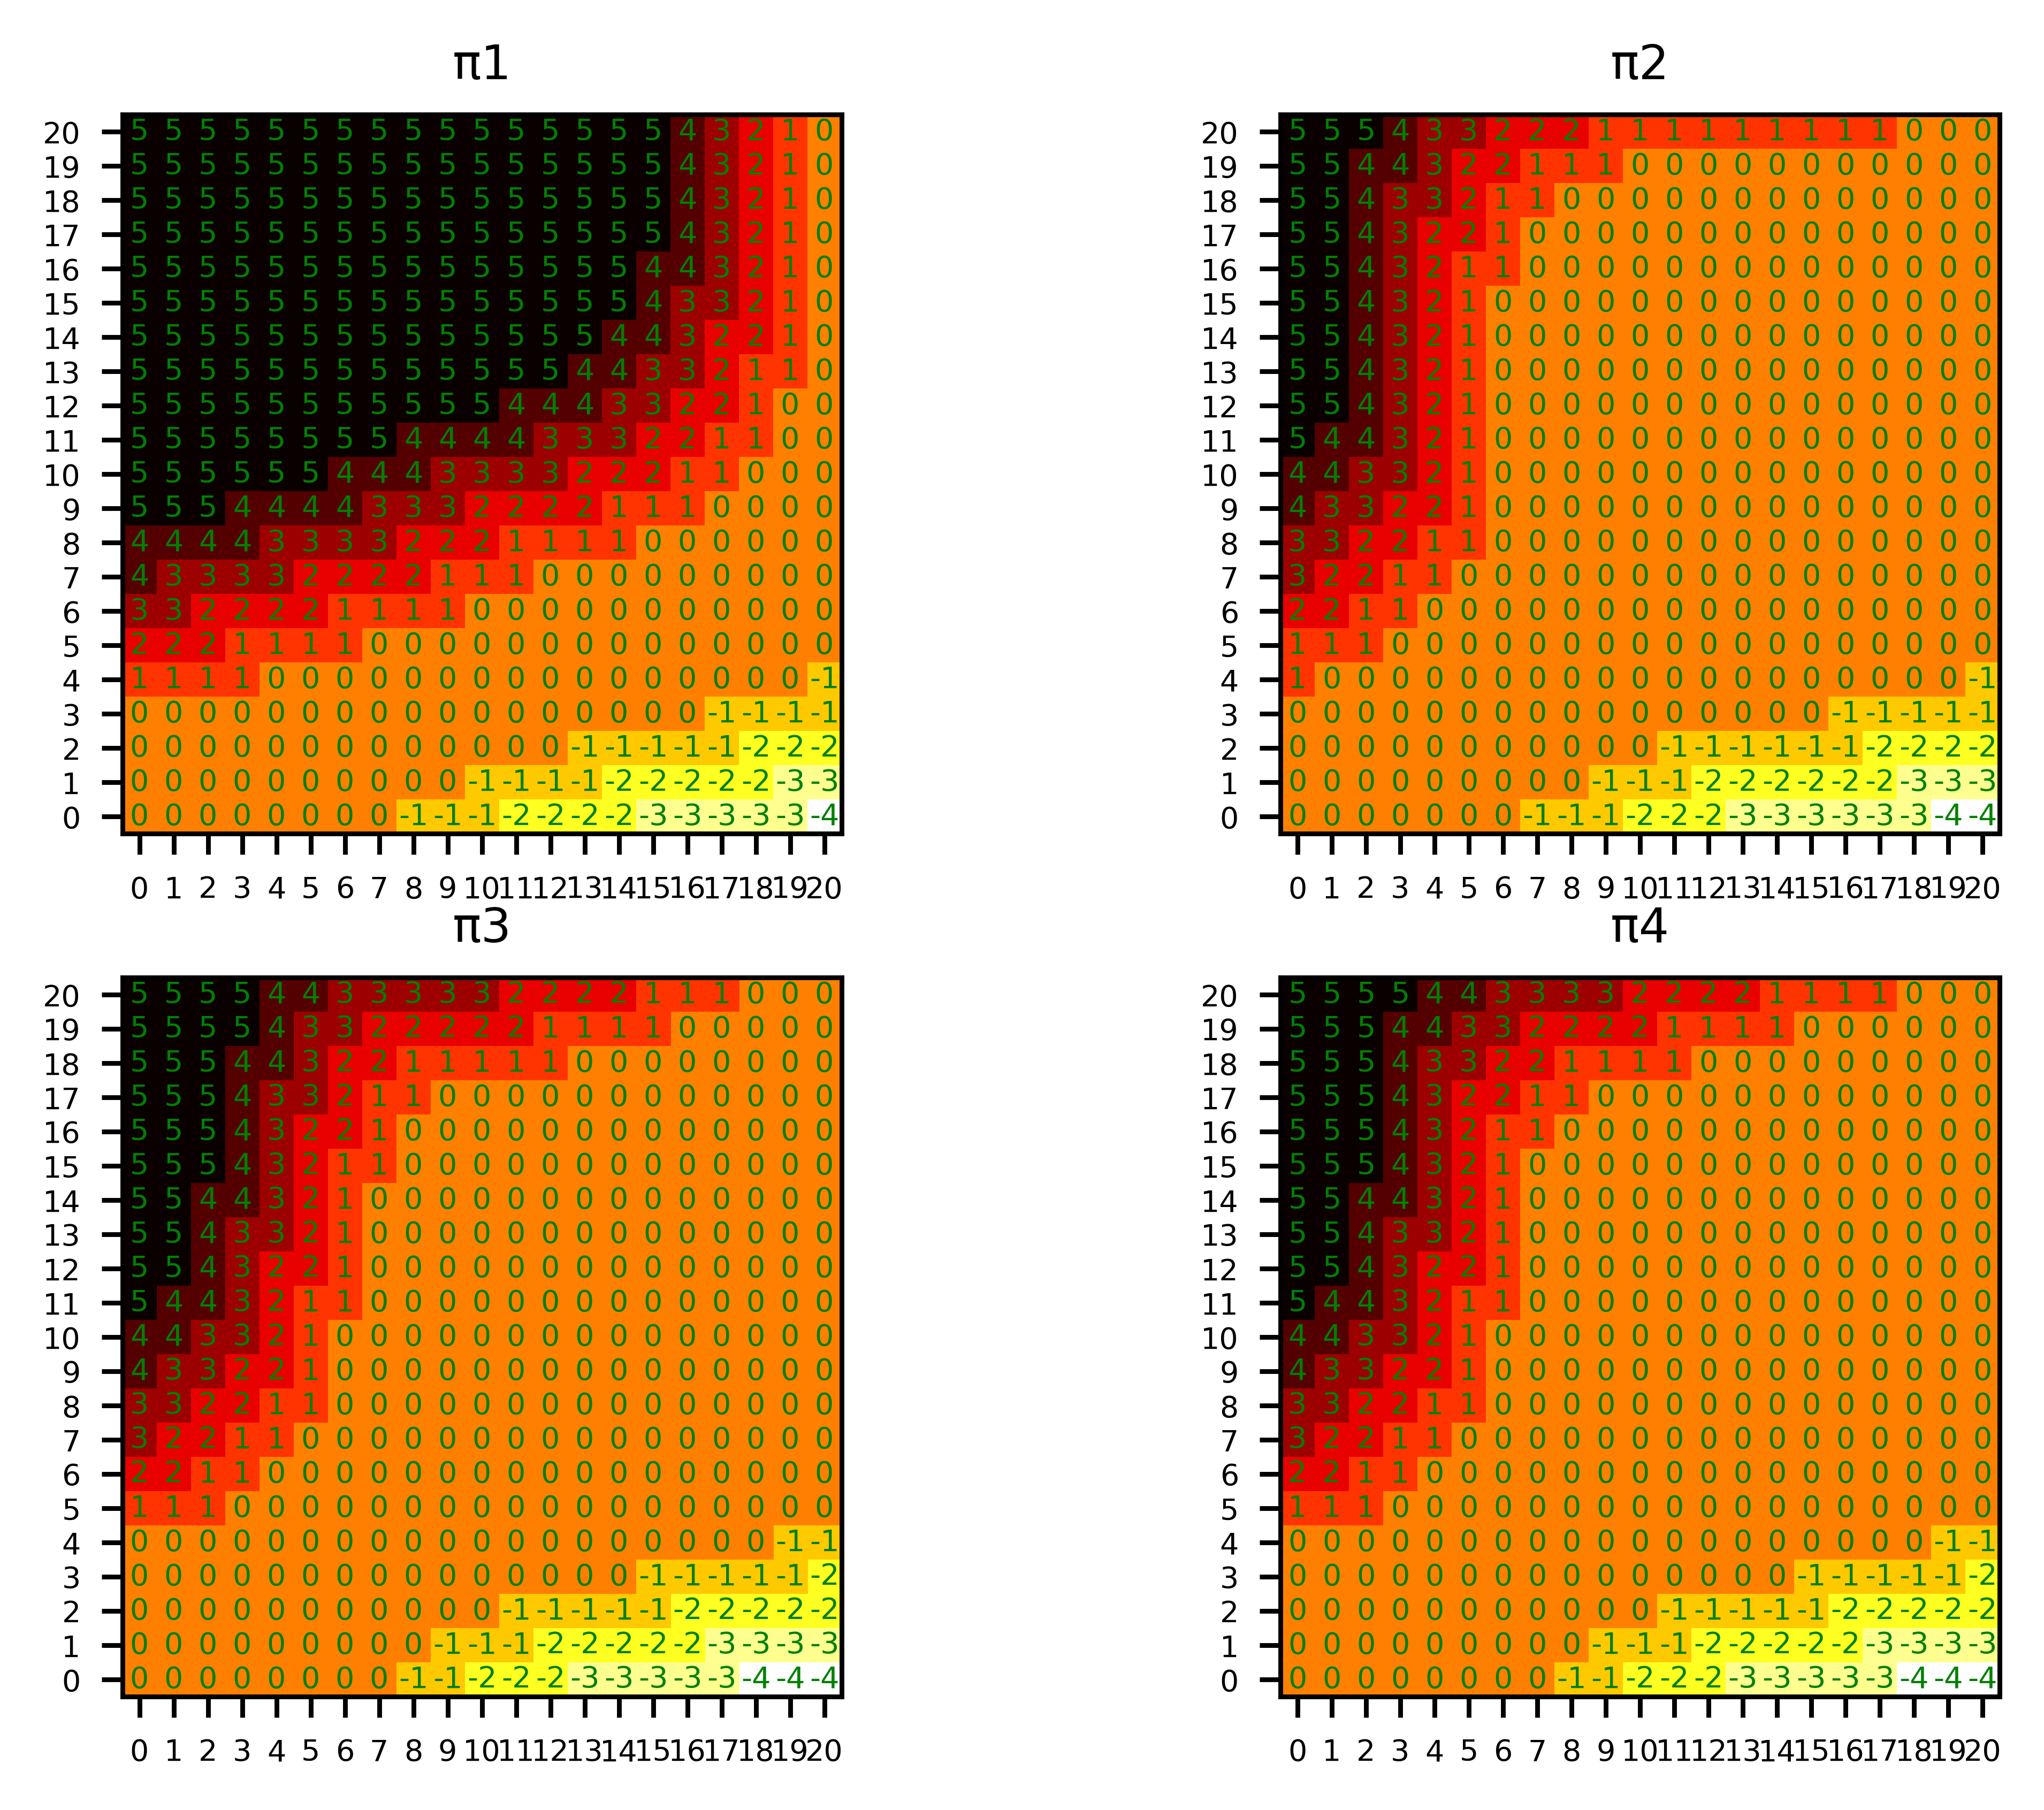

In [12]:
def draw(x,y,heatlist,title,plot_num):
    fig=plt.figure(1,dpi=800)
    ax=fig.add_subplot(220+plot_num) # 221,222,223,224
    #定义横纵坐标的刻度
    ax.set_xticks(np.arange(len(x)),labels=x,fontsize=5)
    ax.set_yticks(np.arange(len(y)),labels=y,fontsize=5)
    
    im=ax.imshow(heatlist,cmap=plt.cm.hot_r)
    
    for i in range(len(y)):
        for j in range(len(x)):
            text=ax.text(j,i,heatlist[i][j],ha="center",va="center",color="g",fontsize=5)
            
    plt.title(title,fontsize=8)
    
    
    
x=[]
y=[]
#定义热图的横纵坐标
for i in range(21):
    x.append(i)
    y.append(20-i)

title='π'
for i in range(4):
    heatlist=[]
    for j in range(21):
        heatlist.append(iter_pi[i][20-j])
    d = draw(x,y,heatlist,title+str(i+1),i+1)